#DQN, Function Approximation, Peformance tricks

In this lab we study the basics of Q learning with function approximation by neural networks.

In [ ]:
# Installing dependencies for visualization
!apt-get -qq -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip -q install gymnasium[classic_control]
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay

E: Unable to locate package libcusparse8.0
E: Couldn't find any package by glob 'libcusparse8.0'
E: Couldn't find any package by regex 'libcusparse8.0'
E: Unable to locate package libnvrtc8.0
E: Couldn't find any package by glob 'libnvrtc8.0'
E: Couldn't find any package by regex 'libnvrtc8.0'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.1/962.1 kB 39.8 MB/s eta 0:00:00


In [ ]:
import glob
import random
import time
import collections
from typing import List, Tuple, Dict, Any

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, clone_model
import matplotlib.pyplot as plt

from base64 import b64encode
from IPython.display import HTML
from pyvirtualdisplay import Display

# Start virtual display
display = Display(visible=0, size=(1024, 768))
display.start()


def show_video(file_name: str):
    mp4 = open(file_name, "rb").read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML(
        """
    <video width=480 controls>
        <source src="%s" type="video/mp4">
    </video>
    """
        % data_url
    )

We will start by defining some useful data structure:

In [ ]:
Transition = collections.namedtuple(
    "transition", ["state", "action", "reward", "done", "next_state"]
)

## CartPole
Debugging DQN is typically a complicated process, thus we have to start with a simple environment, that can be quickly iterated. Let's first construct working DQN for CartPole problem. We will use a small modification of the orginal CartPole env, we do reward reshape (to make problem easier for DQN):

In [ ]:
class ModifiedCartPole:
    def __init__(self):
        self.env = gym.make("CartPole-v1")

    def reset(self) -> np.ndarray:
        return self.env.reset()[0]

    def step(self, action) -> Tuple[np.ndarray, float, bool, Dict[Any, Any]]:
        obs, reward, done, truncated, _ = self.env.step(action)
        if done:
            reward = -10
        return obs, reward / 10, done or truncated, {}

##Q-network.
First we must create a network to approximate Q(s, a). We have two natural design choices:
- Q-network takes two inputs: state s and action a and predicts one value Q(s,a)
- Q-network takes one input: state s, and predicts a vector of Q(s, a) for all possible actions.

We will follow the second design choice (one of the reasons is that such network can faster predict the best action).

**Exercise: fill the code below to create Q-network** Create a simple fully connected network with `num_layers` layers each with 64 neurons. The input is a vector of size `input_size`, and the output is a vector of size `num_actions` (we have 2 actions in cartpole).

In [ ]:
def make_cartpole_network(
    input_size: int = 4,
    num_action: int = 2,
    num_layers: int = 3,
    learning_rate: float = 1e-4,
    weight_decay: float = 0.0,
) -> Model:
    input_state = Input(batch_shape=(None, input_size))
    #### TODO ####
    x = input_state
    for _ in range(num_layers):
        x = Dense(64, activation='relu')(x)
    output = Dense(num_action)(x)
    #### END ####
    model = Model(inputs=input_state, outputs=output)
    model.compile(loss="mse", optimizer=Adam(learning_rate=learning_rate))
    return model

## Building DQN

We will start with some utils functions:

**Exercise: read the following functions, implement epsilon greedy policy**

In [ ]:
def predict_q_values(q_network: Model, state: np.ndarray) -> np.ndarray:
    """Makes a prediction for a single state and returns array of Q-values"""
    return q_network.predict(np.array([state]), verbose=0)[0]


def choose_best_action(q_network: Model, state: np.ndarray) -> int:
    """Chooses best action according to Q-network"""
    action_values = predict_q_values(q_network, state)
    best_action = np.argmax(action_values)
    return best_action


def evaluate_state_batch(
    target_network: Model, state_batch: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """This function can evaluate the whole batch of states at once, it
    is very useful to speedup the training when we calculate targets
    Arguments:
      - state_batch: list of states to evaluate
    Returns:
      - best actions: list of best action for every state
      - best vals: list of best state-action values for very state
      - action_values: list of all action-values for each state

    Here we named the argument target network instead of q_network, because this
    function will be used with target network.
    """
    action_values = target_network.predict(np.array(state_batch), verbose=0)
    best_actions = np.argmax(action_values, axis=-1)
    best_vals = np.max(action_values, axis=-1)
    return best_actions, best_vals, action_values


def choose_action(q_network: Model, state, epsilon: float) -> int:
    """Implement epsilon-greedy policy."""
    #### TODO ####
    if random.random() < epsilon:
        action = random.randint(0,1)
    else:
        action = choose_best_action(q_network, state)
    #### END ####
    return action

While running the episodes we will collect transitions and store them in a replay_buffer, which is just a list of transitions. Before we write a code for running episodes we must first prepare a function that prepares training (since it is used while running the game) and a one for doing the training.

**Exercise: the training protocole is the heart of DQN. Fill the gaps in the following function. Specific tasks are described in multiline comments.**

In [ ]:
def sample_minibatch(
    replay_buffer: List[Transition], mini_batch_size: int
) -> List[Transition]:
    """Write a code to choose random samples from replay_buffer.
    Choose mini_batch_size of samples and collect them in replay_batch variable.
    replay_batch must be a list of transitions.
    Hint: you can use random.sample method."""
    replay_batch: list
    #### TODO ####
    replay_batch = random.sample(replay_buffer, mini_batch_size)
    #### END ####
    return replay_batch


def compute_target(
    transition: Transition, next_state_value: float, gamma: float
) -> float:
    """Compute TD(0) target based on current transition and next state value.
    Remember to treat last state of the episode separately.
    """
    #### TODO ####
    if transition.done:
        target = transition.reward
    else:
        target = transition.reward + gamma * next_state_value
    #### END ####
    return target


def prepare_update_targets(
    target_network: Model,
    replay_buffer: List[Transition],
    mini_batch_size: int,
    gamma: float = 0.99,
) -> Tuple[np.ndarray, np.ndarray]:
    replay_batch = sample_minibatch(replay_buffer, mini_batch_size)

    # We will collect all states and next_states from the batch of transitions
    # to evaluate them at once.
    next_state_batch = [transition.next_state for transition in replay_batch]
    state_batch = [transition.state for transition in replay_batch]

    _, next_state_values, _ = evaluate_state_batch(target_network, next_state_batch)
    _, _, state_action_vals = evaluate_state_batch(target_network, state_batch)

    train_x, train_y = [], []
    for transition, state_vals, next_state_value in zip(
        replay_batch, state_action_vals, next_state_values
    ):
        """Prepare x, y training pairs for supervised model update:
        - x is a state,
        - y is a vector of values for each action.
        Note, that we only compute new targets for one action (the one in the trajectory),
        values for other actions should remain unchanged.
        Hint: use copy() method to make sure you are not modifying data in replay buffer.
        """
        # Copy transition.state to x, use copy() method
        action = transition.action
        x = transition.state.copy()
        # Copy state_vals vector to y
        y = state_vals.copy()

        y[action] = compute_target(transition, next_state_value, gamma)

        train_x.append(x)
        train_y.append(y)

    return np.array(train_x), np.array(train_y)

**Exercise: fill the gaps in the update function**

In [ ]:
def update(
    q_network: Model,
    target_network: Model,
    replay_buffer: List[Transition],
    mini_batch_size: int,
    gamma: float,
) -> float:
    """Prepare training batch (x and y) and update the model on it.
    For models in keras you can use train_on_batch method. Checkout its
    interface in the documentation."""
    #### TODO ####
    x, y = prepare_update_targets(target_network,
                                  replay_buffer,
                                  mini_batch_size,
                                  gamma)

    loss = q_network.train_on_batch(x, y)
    #### END ####
    return loss

Now, let us code the heart of DQN algorithm: the function that runs an epizode and trains Q-network.

**Exercise: fill the code in run_one_episode function**

In [ ]:
def run_one_episode(
    q_network: Model,
    target_network: Model,
    env: ModifiedCartPole,
    epsilon: float,
    steps_so_far: int,
    replay_buffer: List[Transition],
    mini_batch_size: int,
    update_target_every_n_steps: int,
    gamma: float,
    replay_buffer_max: int
) -> Tuple[int, List[float]]:
    done = False
    episode_steps = 0
    state = env.reset()
    ep_actions = []
    loss_history = []
    while not done:
        # Implement env interaction
        # 1. Select action with eps-greedy policy
        # 2. Advance the env
        # 3. Store recorded transition in the replay buffer
        # Remember to update the `state` variable
        ### TODO ###
        ### END ###
        action = choose_action(q_network, state, epsilon)
        ep_actions.append(action)
        episode_steps += 1
        steps_so_far += 1
        next_state, reward, done, _ = env.step(action)

        new_transition = Transition(state, action, reward, done, next_state)
        if replay_buffer_max != 0:
            if len(replay_buffer) > replay_buffer_max:
                  replay_buffer.pop(0)
        replay_buffer.append(new_transition)
        state = next_state

        if len(replay_buffer) > mini_batch_size:
            # Update the model
            ### TODO ###
            loss = update(q_network, target_network, replay_buffer,
                          mini_batch_size, gamma)
            ### END ###
            loss_history.append(loss)
            if steps_so_far % update_target_every_n_steps == 0:
                print(f"Updating target network")
                target_network.set_weights(q_network.get_weights())

    return episode_steps, loss_history

Finally, we can complete the full DQN algorithm.

In [ ]:
def run_dqn(
    train_steps: int, n_checkpoints: int, use_target_network=True, replay_buffer_max=0
) -> Tuple[List[int], List[float], List[np.ndarray]]:
    # The parameter
    env = ModifiedCartPole()

    # We save several checkpoints to later visualize theit performance
    q_checkpoints = []
    save_q_chepoint_every_n_steps = train_steps / n_checkpoints

    # Here is a set of default parameters (tested), you can try to find better values
    epsilon = 0.4
    min_epsilon = 0.1
    epsilon_decay = 0.99
    gamma = 0.975
    mini_batch_size = 128
    update_target_every_n_steps = 128

    replay_buffer = []

    q_network = make_cartpole_network()
    if use_target_network:
        target_network = make_cartpole_network()
    else:
        target_network = q_network

    steps_so_far = 0

    episode_lengths, loss_history = [], []
    episode_num = 0

    while steps_so_far < train_steps:
        episode_length, loss = run_one_episode(
            q_network,
            target_network,
            env,
            epsilon,
            steps_so_far,
            replay_buffer,
            mini_batch_size,
            update_target_every_n_steps,
            gamma,
            replay_buffer_max
        )
        if epsilon > min_epsilon:
            epsilon *= epsilon_decay
        episode_num += 1
        episode_lengths.append(episode_length)
        if loss is not None:
            loss_history.extend(loss)
        steps_so_far += episode_length
        if (
            steps_so_far - len(q_checkpoints) * save_q_chepoint_every_n_steps
            >= save_q_chepoint_every_n_steps
        ):
            q_checkpoints.append(q_network.get_weights())
        print(
            f"Episode = {episode_num} | steps =  {steps_so_far} | "
            f"episode_length = {episode_length} | epsilon = {epsilon} | "
            f"loss = {np.mean(loss)}"
        )

    return episode_lengths, loss_history, q_checkpoints

Let us now run the training (it may take several minutes to take the training of 5000-8000 steps). Do not expect the reward to grow monotonically. The training typically looks like a noisy process with some drift towards higher returns.

In [ ]:
progress, loss_history, q_checkpoints = run_dqn(2000, 5)

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Episode = 1 | steps =  10 | episode_length = 10 | epsilon = 0.396 | loss = nan
Episode = 2 | steps =  20 | episode_length = 10 | epsilon = 0.39204 | loss = nan
Episode = 3 | steps =  30 | episode_length = 10 | epsilon = 0.3881196 | loss = nan
Episode = 4 | steps =  41 | episode_length = 11 | epsilon = 0.384238404 | loss = nan
Episode = 5 | steps =  49 | episode_length = 8 | epsilon = 0.38039601996 | loss = nan
Episode = 6 | steps =  61 | episode_length = 12 | epsilon = 0.3765920597604 | loss = nan
Episode = 7 | steps =  70 | episode_length = 9 | epsilon = 0.372826139162796 | loss = nan
Episode = 8 | steps =  81 | episode_length = 11 | epsilon = 0.36909787777116804 | loss = nan
Episode = 9 | steps =  91 | episode_length = 10 | epsilon = 0.36540689899345635 | loss = nan
Episode = 10 | steps =  104 | episode_length = 13 | epsilon = 0.36175283000352176 | loss = nan
Episode = 11 | steps =  113 | episode_length = 9 | epsilon = 0.35813530170348656 | loss = nan
Episode = 12 | steps =  122 | ep

In [ ]:
def visualize_progress(progress: List[int], loss_history: List[float]):
    plt.clf()
    plt.plot(progress, label="DQN progress")
    smoothed_progress = [0]
    for x in progress:
        smoothed_progress.append(0.8 * smoothed_progress[-1] + 0.2 * x)
    plt.plot(smoothed_progress, label="DQN learning (smoothed)")
    plt.legend(loc="upper left")
    plt.show()

    plt.clf()
    plt.plot(loss_history, label="Loss")
    plt.legend(loc="upper left")
    plt.show()

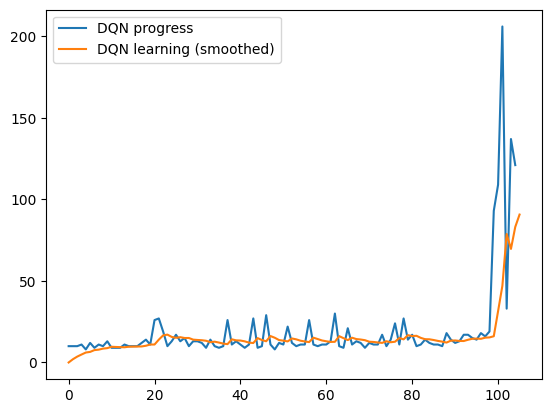

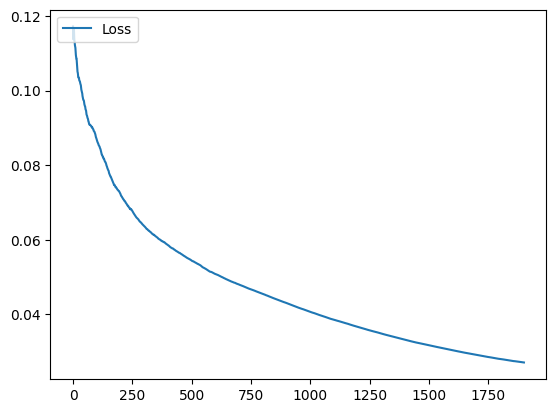

In [ ]:
visualize_progress(progress, loss_history)

Let us see how the agent performs across the training:

In [ ]:
def record_checkpoint(checkpoint: np.ndarray):
    # This function records an episode of the agent equipped with a given chekpoint
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    model = make_cartpole_network()
    model.set_weights(checkpoint)
    max_ep_len = 200
    envw = gym.wrappers.RecordVideo(env, "./", name_prefix="cartpole-video")
    (o, info_), d, ep_len = envw.reset(), False, 0
    while not (d or (ep_len == max_ep_len)):
        envw.render()
        action = choose_best_action(model, o)
        o, r, d, t, info = envw.step(action)
    envw.close()

Lets take a look at first saved chekpoint:

In [ ]:
record_checkpoint(q_checkpoints[0])
file_name = glob.glob("cartpole-video*.mp4")[0]
show_video(file_name)

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


And the last:

In [ ]:
record_checkpoint(q_checkpoints[-1])
file_name = glob.glob("cartpole-video*.mp4")[0]
show_video(file_name)

# Ablation study
Let's see the what happens to DQN performance after turning off some of its mechanisms:
- target network
- sampling from replay_buffer

**Exercise: turn off the usage of target networks.** You can for example modify the code of run_dqn() and set target_network = q_network. Compare the results with previous run.

**Exercise: add the size limit to replay buffer.** Add a code to run_dqn() that clips its size to a given limit. What happens if the replay buffer is very small?

In [ ]:
progress2, loss_history2, q_checkpoints2 = run_dqn(2000, 5, False)

Episode = 1 | steps =  12 | episode_length = 12 | epsilon = 0.396 | loss = nan
Episode = 2 | steps =  27 | episode_length = 15 | epsilon = 0.39204 | loss = nan
Episode = 3 | steps =  42 | episode_length = 15 | epsilon = 0.3881196 | loss = nan
Episode = 4 | steps =  53 | episode_length = 11 | epsilon = 0.384238404 | loss = nan
Episode = 5 | steps =  62 | episode_length = 9 | epsilon = 0.38039601996 | loss = nan
Episode = 6 | steps =  75 | episode_length = 13 | epsilon = 0.3765920597604 | loss = nan
Episode = 7 | steps =  88 | episode_length = 13 | epsilon = 0.372826139162796 | loss = nan
Episode = 8 | steps =  109 | episode_length = 21 | epsilon = 0.36909787777116804 | loss = nan
Episode = 9 | steps =  121 | episode_length = 12 | epsilon = 0.36540689899345635 | loss = nan
Episode = 10 | steps =  145 | episode_length = 24 | epsilon = 0.36175283000352176 | loss = 0.042992912232875824
Episode = 11 | steps =  207 | episode_length = 62 | epsilon = 0.35813530170348656 | loss = 0.0335164777934

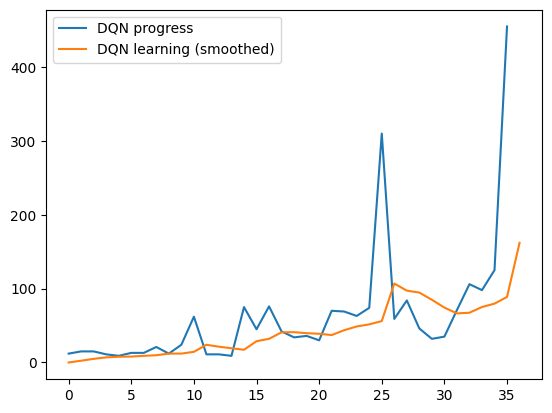

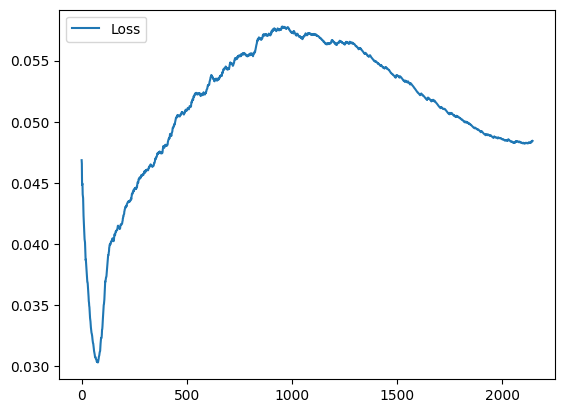

In [ ]:
visualize_progress(progress2, loss_history2)

In [ ]:
progress3, loss_history3, q_checkpoints3 = run_dqn(2000, 5, False, 500)

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Episode = 1 | steps =  13 | episode_length = 13 | epsilon = 0.396 | loss = nan
Episode = 2 | steps =  22 | episode_length = 9 | epsilon = 0.39204 | loss = nan
Episode = 3 | steps =  31 | episode_length = 9 | epsilon = 0.3881196 | loss = nan
Episode = 4 | steps =  40 | episode_length = 9 | epsilon = 0.384238404 | loss = nan
Episode = 5 | steps =  53 | episode_length = 13 | epsilon = 0.38039601996 | loss = nan
Episode = 6 | steps =  83 | episode_length = 30 | epsilon = 0.3765920597604 | loss = nan
Episode = 7 | steps =  96 | episode_length = 13 | epsilon = 0.372826139162796 | loss = nan
Episode = 8 | steps =  110 | episode_length = 14 | epsilon = 0.36909787777116804 | loss = nan
Episode = 9 | steps =  123 | episode_length = 13 | epsilon = 0.36540689899345635 | loss = nan
Episode = 10 | steps =  135 | episode_length = 12 | epsilon = 0.36175283000352176 | loss = 0.07439126074314117
Episode = 11 | steps =  148 | episode_length = 13 | epsilon = 0.35813530170348656 | loss = 0.0678481906652450

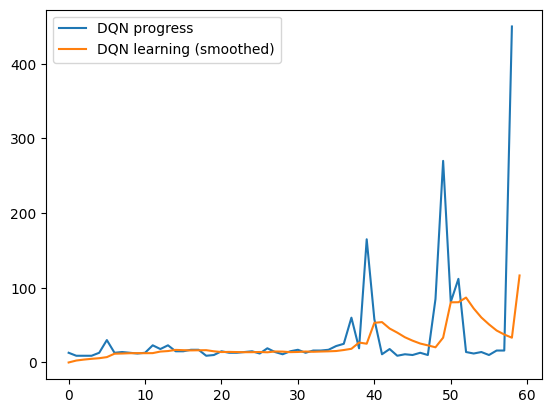

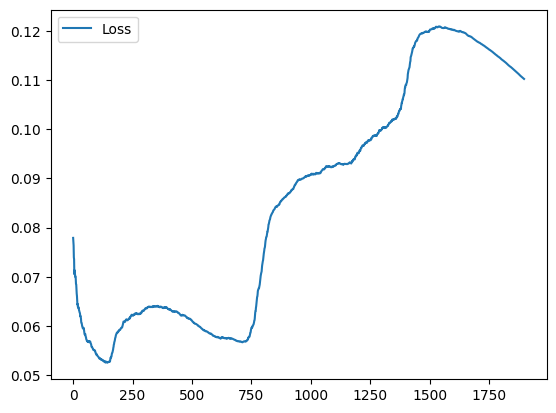

In [ ]:
visualize_progress(progress3, loss_history3)